## Spot occultation

In this tutorial we demonstrate how to use spotter to model the occultation of a non-uniform surface - here with a spot - by a transited exoplanet.

```{note}
This tutorial requires [jaxoplanet]()
```

In [129]:
import jax

jax.config.update("jax_enable_x64", True)

from spotter import Star, show, core
from spotter.light_curves import transit_light_curve
from jaxoplanet.orbits.keplerian import Central, Body, System
from jaxoplanet.orbits import TransitOrbit
import numpy as np

r = 0.2
body = Body(time_transit=0.0, period=1.0, radius=r, impact_param=0.0)
system = System().add_body(body)

star = Star.from_sides(30, u=(0.1, 0.5))
star = star.set(y=1 - 0.5 * core.spot(star.sides, 0.0, 0.2, 0.2, 20))


def planet_coords(system, time):
    xos, yos, zos = system.relative_position(time)
    x = (xos[0] / system.central.radius).magnitude
    y = (yos[0] / system.central.radius).magnitude
    z = (zos[0] / system.central.radius).magnitude
    return y, x, z


def flux_model(star, system, time):
    coords = planet_coords(system, time)
    flux = jax.vmap(
        lambda coords, time: transit_light_curve(star, *coords, r=r, time=time)
    )(coords, time).T[0]
    return flux

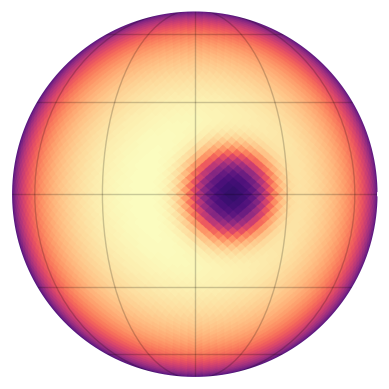

In [130]:
show(star)

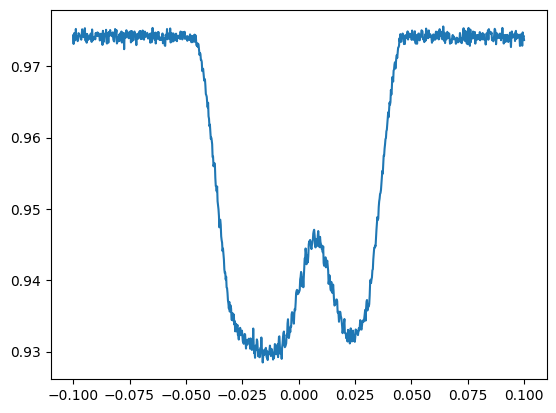

In [131]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(-0.1, 0.1, 1000)

flux = flux_model(star, system, time) + np.random.randn(1000) * 0.0005
plt.plot(time, flux)

In [116]:
import tinygp
from spotter.kernels import GreatCircleDistance

kernel = 0.1 * tinygp.kernels.Matern52(0.2, distance=GreatCircleDistance())
gp = tinygp.GaussianProcess(kernel, core.vec(star.sides))

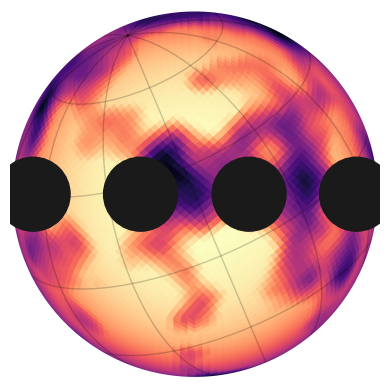

In [126]:
y = gp.sample(jax.random.PRNGKey(20), shape=(1,))[0]
star = star.set(y=1.0 - 0.7 * y.clip(0.0, 1.0), obl=0.4, inc=1.2)

show(star)

for t in np.linspace(time.min(), time.max(), 10):
    y, x, _ = planet_coords(system, t)
    circle = plt.Circle((x, y), r, color="0.1", zorder=10)
    plt.gca().add_artist(circle)

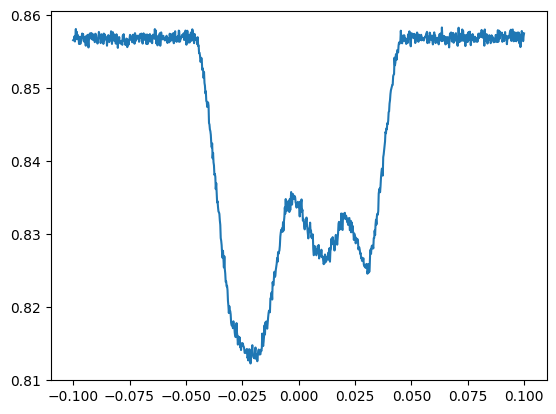

In [128]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(-0.1, 0.1, 1000)

flux = flux_model(star, system, time) + np.random.randn(len(time)) * 0.0005
plt.plot(time, flux)